# Kaggle Readability prize playground

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize

import os

In [7]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [8]:
train_set = '../datasets/commonlitreadabilityprize/train.csv'
test_set = '../datasets/commonlitreadabilityprize/test.csv'
submit_sample = '../datasets/commonlitreadabilityprize/sample_submission.csv'

In [9]:
df = pd.read_csv(train_set)
df.columns

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')

## Columns
* id - unique ID for excerpt
* url_legal - URL of source - this is blank in the test set.
* license - license of source material - this is blank in the test set.
* excerpt - text to predict reading ease of
* target - reading ease
* standard_error - measure of spread of scores among multiple raters for each excerpt. Not included for test data.

In [11]:
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [12]:
len(df)

2834

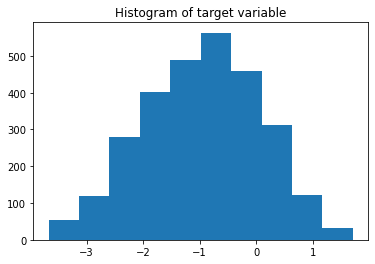

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64


In [13]:
plt.hist(df.target, bins = 10)
plt.title("Histogram of target variable")
plt.show()
print(df.target.describe())

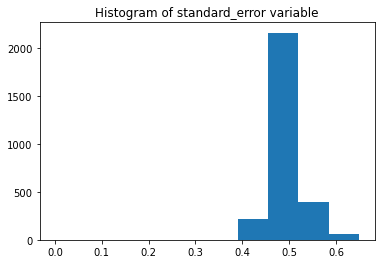

count    2834.000000
mean        0.491435
std         0.034818
min         0.000000
25%         0.468543
50%         0.484721
75%         0.506268
max         0.649671
Name: standard_error, dtype: float64


In [14]:
plt.hist(df.standard_error, bins = 10)
plt.title("Histogram of standard_error variable")
plt.show()
print(df.standard_error.describe())

## Cleaning
* Hay algunos NaN pero en columnas irrelevantes.
* Ojo, hay celdas 0.0 en una fila: por eso la distorsión en el min del std_err

In [15]:
df[df['target'] == 0.0]

,id,url_legal,license,excerpt,target,standard_error
106,436ce79fe,NaN,NaN,"The sun was shining in a cloudless sky, and no...",0.0,0.0


In [16]:
df = df.drop([106]) # why do we erase this line? is better to keep all the data. Zero seems to be a qualification.

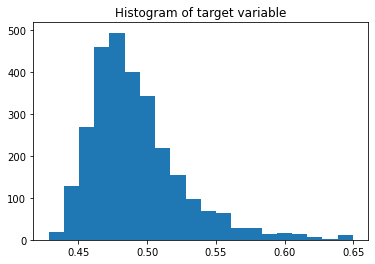

count    2833.000000
mean        0.491609
std         0.033577
min         0.428233
25%         0.468553
50%         0.484748
75%         0.506304
max         0.649671
Name: standard_error, dtype: float64


In [11]:
plt.hist(df.standard_error, bins = 20)
plt.title("Histogram of standard_error variable")
plt.show()
print(df.standard_error.describe())

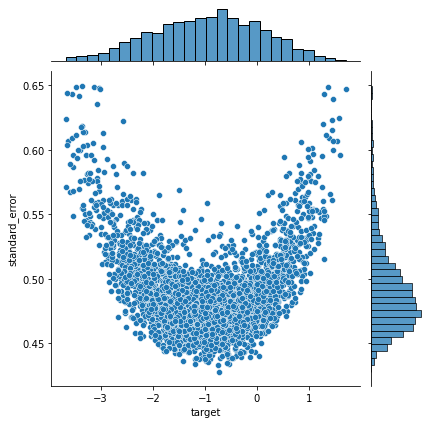

In [17]:
sns.jointplot(x='target', y='standard_error', data=df)

## De acuerdo
* Veamos los textos donde los raters estuvieron de acuerdo (bajo spread) sobre su facilidad de lectura:
* Ordenado por mayor target (y observemos el standard error).


## Los mejores textos:

In [18]:
mejores = df[['id','excerpt', 'target', 'standard_error']].sort_values('target', ascending = False)[:20]

In [19]:
mejores.head()

,id,excerpt,target,standard_error
2829,25ca8f498,When you think of dinosaurs and where they liv...,1.711390,0.646900
981,849971671,"For her last birthday, Sisanda had a special t...",1.597870,0.596349
808,8f35441e3,"Every day, Emeka's father took him to school i...",1.583847,0.624776
1014,7a1d484be,More people came to the bus stop just before 9...,1.541672,0.606997
1066,016913371,Grandma's garden was wonderful. It was full of...,1.467665,0.599600


## Los peores textos:

In [20]:
peores = df[['id','excerpt', 'target', 'standard_error']].sort_values('target', ascending = True)[:20]
peores.head()

,id,excerpt,target,standard_error
1705,4626100d8,"The commutator is peculiar, consisting of only...",-3.676268,0.623621
1128,493b80aa7,The Dunwich horror itself came between Lammas ...,-3.668360,0.571404
1754,fe44cbd14,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.642892,0.644398
1752,284eaa5ad,As to surface-slope its measurement—from nearl...,-3.639936,0.603819
1720,9e9eacb49,"The tree is dioecious, bearing male catkins on...",-3.636834,0.606822


## Observaciones
* 1. 
* 2. 

# Feature Engineering: Generating some basic features

In [21]:
# Here we are taking the NLP statistics by hand...did you mention we have a library for this?
df['word_count'] = df['excerpt'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['excerpt'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['char_count'] / df['word_count']

df['unique_words_count'] = df['excerpt'].apply(lambda x: len(set( x.split(' ') ))) # Neat usage of the Set! :D
df['diversity'] = df['unique_words_count'] / df['word_count']

df.head()

,id,url_legal,license,excerpt,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,179,992,5.541899,112,0.625698
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,169,937,5.544379,123,0.727811
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,166,908,5.469880,124,0.746988
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,164,909,5.542683,117,0.713415
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,147,723,4.918367,51,0.346939


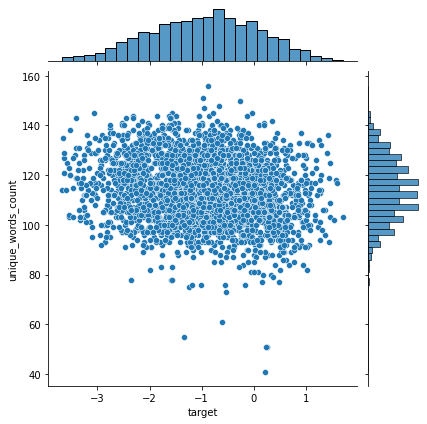

In [22]:
sns.jointplot(x='target', y='unique_words_count', data=df) # I do not understand what are you looking for with this chart...

# Data wrangling


In [26]:
df_clean = df.drop(columns=['license','url_legal'])

In [28]:
df_clean.describe() #Everyonhe seems to have more or less the same diversity; this is due to the fact that we didn't clean up the text from the articles and other connectors.

,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity
count,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000,2833.000000
mean,-0.959657,0.491609,172.992940,971.804095,5.619931,113.901518,0.659472
std,1.033604,0.033577,16.967398,117.216975,0.429843,12.818148,0.051414
min,-3.676268,0.428233,135.000000,669.000000,4.252632,41.000000,0.235632
25%,-1.691501,0.468553,159.000000,885.000000,5.310811,105.000000,0.630682
50%,-0.913322,0.484748,175.000000,971.000000,5.573333,114.000000,0.663366
75%,-0.203079,0.506304,188.000000,1058.000000,5.872611,123.000000,0.693182
max,1.711390,0.649671,205.000000,1341.000000,8.083871,156.000000,0.800000


**Conclusion:** We got 205 possible columns to play with.

Some interesting libs to research:

* https://www.nltk.org/
* https://polyglot.readthedocs.io/en/latest/index.html

In [35]:
# Let's create a new dataframe with a column by word.
words_array = df_clean['excerpt'].str.split(' ',expand=True)

In [36]:
words_array.shape

(2833, 205)

In [38]:
words_array.describe()

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
count,2833,2833,2833,2833,2833,2833,2833,2833,2833,2833,...,204,168,107,64,32,12,8,4,2,2
unique,820,1345,1253,1239,1285,1363,1376,1364,1353,1367,...,162,143,95,58,32,12,7,4,2,2
top,The,the,a,the,the,the,the,the,the,the,...,the,the,to,the,Nathaniel,its,and,"architect.""",same,water.
freq,485,172,154,158,224,193,176,185,188,163,...,13,11,7,5,1,1,2,1,1,1


In [41]:
words_array.head()

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,When,the,young,people,returned,to,the,"ballroom,",it,presented,...,None,None,None,None,None,None,None,None,None,None
1,All,through,dinner,"time,",Mrs.,Fayre,was,somewhat,"silent,",her,...,None,None,None,None,None,None,None,None,None,None
2,As,Roger,had,"predicted,",the,snow,departed,as,quickly,as,...,None,None,None,None,None,None,None,None,None,None
3,And,outside,before,the,palace,a,great,garden,was,walled,...,None,None,None,None,None,None,None,None,None,None
4,Once,upon,a,time,there,were,Three,Bears,who,lived,...,None,None,None,None,None,None,None,None,None,None


In [44]:
df_final = pd.concat([df_clean, words_array], axis=1)

In [45]:
df_final.head()

,id,excerpt,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity,0,...,195,196,197,198,199,200,201,202,203,204
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,179,992,5.541899,112,0.625698,When,...,None,None,None,None,None,None,None,None,None,None
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,169,937,5.544379,123,0.727811,All,...,None,None,None,None,None,None,None,None,None,None
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,166,908,5.469880,124,0.746988,As,...,None,None,None,None,None,None,None,None,None,None
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,164,909,5.542683,117,0.713415,And,...,None,None,None,None,None,None,None,None,None,None
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,147,723,4.918367,51,0.346939,Once,...,None,None,None,None,None,None,None,None,None,None


In [47]:
df_final_clean = df_final.drop(columns=['excerpt'])

In [49]:
df_indexed = df_final_clean.set_index('id')
df_indexed.head()

,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity,0,1,2,...,195,196,197,198,199,200,201,202,203,204
id,,,,,,,,,,,,,,,,,,,,,
c12129c31,-0.340259,0.464009,179,992,5.541899,112,0.625698,When,the,young,...,None,None,None,None,None,None,None,None,None,None
85aa80a4c,-0.315372,0.480805,169,937,5.544379,123,0.727811,All,through,dinner,...,None,None,None,None,None,None,None,None,None,None
b69ac6792,-0.580118,0.476676,166,908,5.469880,124,0.746988,As,Roger,had,...,None,None,None,None,None,None,None,None,None,None
dd1000b26,-1.054013,0.450007,164,909,5.542683,117,0.713415,And,outside,before,...,None,None,None,None,None,None,None,None,None,None
37c1b32fb,0.247197,0.510845,147,723,4.918367,51,0.346939,Once,upon,a,...,None,None,None,None,None,None,None,None,None,None


## Let's try training a simple neural network for prediction

In [50]:
# Preparing the data...
X = df_final.drop(columns=['target', 'standard_error']).to_numpy()
y = df_final['target'].to_numpy()

In [51]:
X.shape

(2833, 212)

In [52]:
y.shape

(2833,)

In [53]:
# The simplest of the simplest: a perceptron - we do this to stablish a base line - https://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# Split the data...
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Defining the model & Training.
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train) # This is absolutely arbitrary, we are just looking...


ValueError: could not convert string to float: '31f4701e4'

In [ ]:
# Let's try to predict: (we need first to prepare all the test set)
regr.predict(X_test[:2])
print(regr.score(X_test, y_test))

In [ ]:
# TODO: 
# 1)build up the PROPOSED test set with the proper format, 
# 2) construct a SME metric as well to gain further comparison with other algorithms.